# Neural Computing Coursework 
### Morteza Layegh Mirhosseini --- Student ID : 220003166

## libraries 

In [1]:
import numpy as np
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt
import time 
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from torch.optim import Adam
from skorch.callbacks import EpochScoring
from skorch.callbacks import EarlyStopping
from skorch.dataset import ValidSplit
from skorch import NeuralNetClassifier
import pickle


## Initial Analysis & Data Pre-processing

In [2]:
#Set the seed
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)
torch.manual_seed(1234)


data= pd.read_csv('BankChurners.csv')
X = data.iloc[:, 2:-2].values
y = data.iloc[:, 1].values
print(X)
print(y)

[[45 'M' 3 ... 42 1.625 0.061]
 [49 'F' 5 ... 33 3.714 0.105]
 [51 'M' 3 ... 20 2.333 0.0]
 ...
 [44 'F' 1 ... 60 0.818 0.0]
 [30 'M' 2 ... 62 0.722 0.0]
 [43 'F' 2 ... 61 0.649 0.189]]
['Existing Customer' 'Existing Customer' 'Existing Customer' ...
 'Attrited Customer' 'Attrited Customer' 'Attrited Customer']


## EDA

In [3]:
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [4]:
data['Attrition_Flag'].unique()

array(['Existing Customer', 'Attrited Customer'], dtype=object)

# Balance check

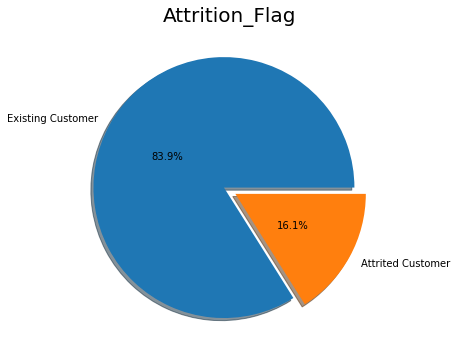

In [5]:

labels = ['Existing Customer', 'Attrited Customer']
data1 = [data['Attrition_Flag'].value_counts()[0],
         data['Attrition_Flag'].value_counts()[1]
        ]
fig1, ax1 = plt.subplots(figsize=[15,6])
ax1.pie(data1, labels=labels,explode=[0.05]*2, autopct='%1.1f%%',pctdistance=0.5, shadow=True)
plt.title("Attrition_Flag", fontsize=20);
plt.show()


In [6]:
unique_values, counts = np.unique(y, return_counts=True)
print(unique_values)
print(counts)  

['Attrited Customer' 'Existing Customer']
[1627 8500]


- 0 = attrited customers
- 1 = existing customers

### Encode Categorical Features

 label encoding the target feature

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

lable encoding Gender feature.

In [8]:
le_gender = LabelEncoder()
X[:, 1] = le_gender.fit_transform(X[:, 1])


One Hot Encoding the categorical columns

In [9]:
#returning the categorical columns
categorical_columns = [col for col in data.columns if data[col].dtype == 'object']
categorical_columns

['Attrition_Flag',
 'Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

In [10]:
#Encoding 'Education_Level','Marital_Status','Income_Category','Card_Category'
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [3, 4, 5, 6])], remainder='passthrough')
X = np.array(ct.fit_transform(X))


### Splitting the dataset into the Training set and Test set

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 12 ,stratify=y )


### Balancing the training data using SMOTE method:


In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_train, y_train= smote.fit_resample(X_train, y_train)

### Feature Scaling

In [13]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train) 

X_test = sc.transform(X_test)

In [14]:
pd.DataFrame(X_train).to_csv('./X_train.csv', index=False)
pd.DataFrame(X_test).to_csv('./X_test.csv', index=False)
pd.DataFrame(y_train).to_csv('./y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('./y_test.csv', index=False)

# Read Preprocessed data

In [15]:
X_train= pd.read_csv('X_train.csv').to_numpy()
X_test= pd.read_csv('X_test.csv').to_numpy()
y_train= pd.read_csv('y_train.csv').to_numpy()
y_test= pd.read_csv('y_test.csv').to_numpy()


# SVM 


# experiment 11

In [16]:

import pickle

# # Save the gs instance to a file
# with open('gridsearch_svm.pickle', 'wb') as f:
#     pickle.dump(grid_search, f)

# Load the gs instance from the file
with open('gridsearch_svm.pickle', 'rb') as f:
    gridsearch_svm = pickle.load(f)

# Traning the model CVGridsearch

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


# Define the hyperparameter grid
parameters = {
    'C': [0.01,0.1, 1, 10,20],
    'gamma': [0.01,0.05,0.07, 0.1]
}

# Create the SVM classifier
classifier = SVC(kernel='rbf')


grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5 ,
                           refit=True,
                           verbose=0,
                          n_jobs=-1)

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)



Best Accuracy: 97.01 %
Best Parameters: {'C': 10, 'gamma': 0.1}


# Test the final model and results 

Predict time: 1.7167668342590332
[[ 167  158]
 [  50 1651]]
0.8973346495557749
              precision    recall  f1-score   support

           0       0.77      0.51      0.62       325
           1       0.91      0.97      0.94      1701

    accuracy                           0.90      2026
   macro avg       0.84      0.74      0.78      2026
weighted avg       0.89      0.90      0.89      2026



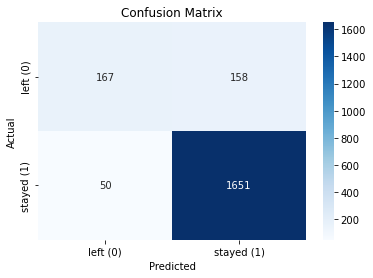

AUC: 0.7422258400036178


In [17]:
# measure prediction time
start_time = time.time()
y_pred = gridsearch_svm.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time

print("Predict time:", prediction_time)

#evaluate 
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

# define the labels for the matrix
labels = ['left (0)', 'stayed (1)']


# create the heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

# add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# show the plot
plt.show()

from sklearn.metrics import precision_recall_fscore_support
# calculate precision, recall, and F1 score
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='macro')

from sklearn.metrics import classification_report, roc_auc_score
print("AUC:", roc_auc_score(y_test, y_pred))

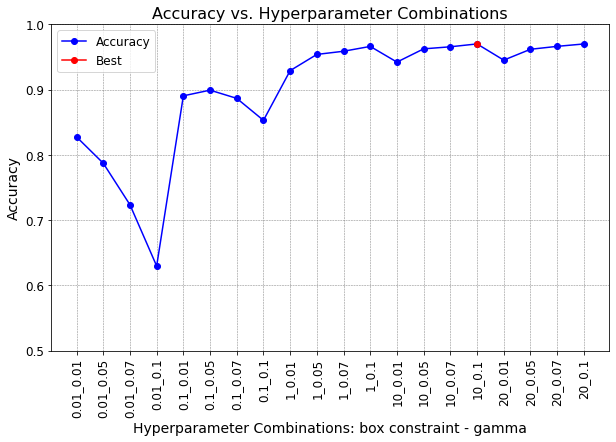

In [18]:

# Get the grid search results
results = gridsearch_svm.cv_results_

# Extract the parameter combinations and the corresponding accuracy scores
params = results['params']
mean_scores = results['mean_test_score']

# Create a list of labels for the x-axis based on the parameter combinations
labels = [str(p) for p in params]
labels = [f"{p['C']}_{p['gamma']}" for p in params]

# Determine the hyperparameter combination with the highest accuracy
best_index = mean_scores.argmax()
best_label = labels[best_index]
best_score = mean_scores[best_index]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the mean test scores
ax.plot(labels, mean_scores, color='blue', marker='o')

# Plot the point with the highest accuracy
ax.plot(best_label, best_score, color='red', marker='o')

# Set the title and axis labels
ax.set_title('Accuracy vs. Hyperparameter Combinations', fontsize=16)
ax.set_xlabel('Hyperparameter Combinations: box constraint - gamma',fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Set the axis tick label font size
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add gridlines
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Add a text to indicate the point with the highest accuracy
#ax.text(best_label, best_score+0.01, f"{best_score:.4f}", color='red', fontsize=12, ha='center', va='bottom')

# Add a legend
ax.legend(['Accuracy', 'Best'], fontsize=12)
plt.ylim(0.5, 1)

# Show the plot
plt.show()


# MLP with skorch 

In [19]:
X_train, y_train = X_train.astype(np.float32), y_train.astype(np.int64)
X_test, y_test = X_test.astype(np.float32), y_test.astype(np.int64)
y_train = np.expand_dims(y_train, axis=-1).astype(np.float32)

In [20]:
auc = EpochScoring(scoring='precision', lower_is_better=False)
Early_stopping= EarlyStopping(monitor='valid_loss', patience=10)

In [21]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units1=64,
            num_units2=32,
            num_units3=16,
            nonlin=F.relu,
            dropout=0.3,
    ):
        super(ClassifierModule, self).__init__()
        self.num_units1 = num_units1
        self.num_units2 = num_units2
        self.num_units3 = num_units3
        self.nonlin = nonlin

        self.dense0 = nn.Linear(36, num_units1)
        self.dropout = nn.Dropout(dropout)
        self.dense1 = nn.Linear(num_units1, num_units2)
        self.dense2 = nn.Linear(num_units2, num_units3)
        self.output = nn.Linear(num_units3,1)
        self.sigmoid = torch.sigmoid

        
    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = self.nonlin(self.dense1(X))
        X = self.dropout(X)
        X = self.nonlin(self.dense2(X))
        X = self.dropout(X)
        X = self.sigmoid(self.output(X))
        return X
    

# Grid search to find the optimal number of nuerons in each layer 

In [28]:
net = NeuralNetClassifier(
    ClassifierModule,
    criterion=nn.BCELoss,
    optimizer=Adam,
    optimizer__weight_decay= 0.0,
    max_epochs=150,
    callbacks= [Early_stopping],
    lr=0.001
)

params = {
    'module__num_units1': [16,32,64],
    'module__num_units2': [16,32,64],
    'module__num_units3': [16,32,64]
}
gs = GridSearchCV(net, params, refit=True, cv=5, scoring='accuracy',n_jobs=-1, verbose=2)

gs.fit(X_train, y_train)

print(gs.best_score_, gs.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7704       0.7243        0.6591  0.6181
      2        0.6527       0.7717        0.6188  0.6399
      3        0.5567       0.6625        0.5903  0.6440
      4        0.4865       0.8140        0.4198  0.6978
      5        0.4000       0.8272        0.3960  0.6758
      6        0.3691       0.8401        0.3742  0.7983
      7        0.3393       0.8515        0.3543  0.7625
      8        0.3112       0.8596        0.3390  0.8026
      9        0.2866       0.8669        0.3231  0.8036
     10        0.2649       0.8713        0.3084  0.7956
     11        0.2470       0.8798        0.2962  0.8236
     12        0.2317       0.8871        0.2853  0.7131
     13        0.2193       0.8945        0.2773  0.7731
     14        0.2087       0.8934        0.2691  0.7177
     15        0.1990     

In [22]:
 import pickle

# # Save the gs instance to a file
# with open('gridsearch_hiddenlayers.pickle', 'wb') as f:
#     pickle.dump(gs, f)

# Load the gs instance from the file
with open('gridsearch_hiddenlayers.pickle', 'rb') as f:
    gs = pickle.load(f)

In [23]:
y_pred=gs.predict(X_test)
#evaluate 
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))


[[ 299   26]
 [ 220 1481]]
0.87857847976308
              precision    recall  f1-score   support

           0       0.58      0.92      0.71       325
           1       0.98      0.87      0.92      1701

    accuracy                           0.88      2026
   macro avg       0.78      0.90      0.82      2026
weighted avg       0.92      0.88      0.89      2026



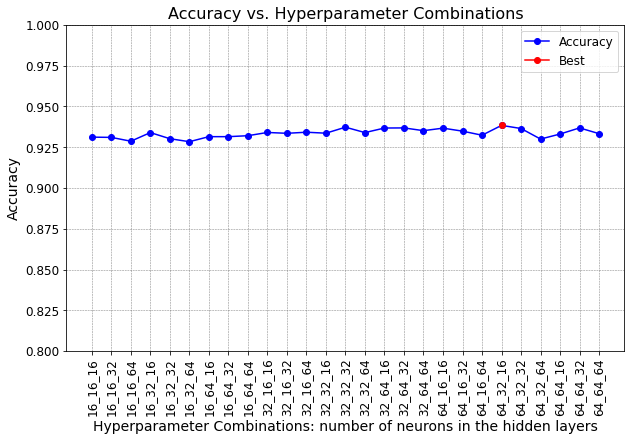

In [28]:
import matplotlib.pyplot as plt

# Get the grid search results
results = gs.cv_results_

# Extract the parameter combinations and the corresponding accuracy scores
params = results['params']
mean_scores = results['mean_test_score']

# Create a list of labels for the x-axis based on the parameter combinations
labels = [str(p) for p in params]
labels = [f"{p['module__num_units1']}_{p['module__num_units2']}_{p['module__num_units3']}" for p in params]

# Determine the hyperparameter combination with the highest accuracy
best_index = mean_scores.argmax()
best_label = labels[best_index]
best_score = mean_scores[best_index]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the mean test scores
ax.plot(labels, mean_scores, color='blue', marker='o')

# Plot the point with the highest accuracy
ax.plot(best_label, best_score, color='red', marker='o')

# Set the title and axis labels
ax.set_title('Accuracy vs. Hyperparameter Combinations', fontsize=16)
ax.set_xlabel('Hyperparameter Combinations: number of neurons in the hidden layers', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Set the axis tick label font size
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add gridlines
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Add a text to indicate the point with the highest accuracy
#ax.text(best_label, best_score+0.01, f"{best_score:.4f}", color='red', fontsize=12, ha='center', va='bottom')

# Add a legend
ax.legend(['Accuracy', 'Best'], fontsize=12)
plt.ylim(0.8, 1)

# Show the plot
plt.show()


# CVGridsearch to find the optimal parameters (LR, dropout,weight_decay)

In [31]:
net = NeuralNetClassifier(
    ClassifierModule,
    criterion=nn.BCELoss,
    optimizer=Adam,
    optimizer__weight_decay= 0.0,
    max_epochs=150,
    callbacks= [Early_stopping],
    lr=0.001
)

params = {
    'lr': [0.001,0.005,0.01],
    'module__dropout': [0,0.1,0.2,0.3],
    'optimizer__weight_decay' : [0.01,0.001,0]
}
gs_lr = GridSearchCV(net, params, refit=True, cv=5, scoring='accuracy',n_jobs=-1, verbose=2)

gs_lr.fit(X_train, y_train)

print(gs_lr.best_score_, gs_lr.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7290       0.5000        0.6829  0.7709
      2        0.6838       0.6732        0.6485  0.8148
      3        0.5728       0.6191        0.6281  0.7785
      4        0.5304       0.8213        0.4252  0.7588
      5        0.4426       0.8353        0.4027  0.8336
      6        0.4186       0.8460        0.3793  0.7681
      7        0.3870       0.8559        0.3577  0.7767
      8        0.3582       0.8625        0.3409  0.7761
      9        0.3350       0.8702        0.3276  0.8115
     10        0.3167       0.8772        0.3083  0.7790
     11        0.2980       0.8809        0.2953  0.7599
     12        0.2798       0.8827        0.2820  0.7257
     13        0.2666       0.8893        0.2709  0.7466
     14        0.2501       0.8923        0.2655  0.7812
     15        0.2453     

    116        0.1059       0.9430        0.1715  0.7323
    117        0.1104       0.9423        0.1737  0.7289
    118        0.0997       0.9426        0.1731  0.7416
    119        0.1033       0.9437        0.1746  0.7495
    120        0.0970       0.9452        0.1749  0.7447
    121        0.1018       0.9456        0.1731  0.8078
    122        0.0951       0.9434        0.1746  0.7094
    123        0.1034       0.9426        0.1703  0.7531
    124        0.1083       0.9445        0.1701  0.6580
Stopping since valid_loss has not improved in the last 10 epochs.
0.9438894057071154 {'lr': 0.001, 'module__dropout': 0.3, 'optimizer__weight_decay': 0}


# saving final model (achieved from CVGridsearch)

In [24]:

# Load the gs instance from the file
with open('gridsearch_lr.pickle', 'rb') as f:
    gridsearch_lr = pickle.load(f)

# Testing final model

In [25]:
# measure prediction time
start_time = time.time()
y_pred = gridsearch_lr.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time

print("Predict time:", prediction_time)

#evaluate 
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

from sklearn.metrics import classification_report, roc_auc_score
print("AUC:", roc_auc_score(y_test, y_pred))


Predict time: 0.0834193229675293
[[ 279   46]
 [ 135 1566]]
0.9106614017769002
              precision    recall  f1-score   support

           0       0.67      0.86      0.76       325
           1       0.97      0.92      0.95      1701

    accuracy                           0.91      2026
   macro avg       0.82      0.89      0.85      2026
weighted avg       0.92      0.91      0.91      2026

AUC: 0.8895482295482294


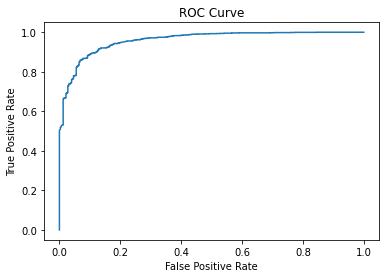

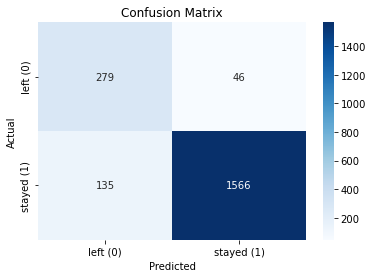

In [26]:
# import necessary libraries
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# get the predicted probabilities and true labels for the test set
y_pred_proba = gridsearch_lr.predict_proba(X_test)[:, 1]
y_true = y_test

# calculate the false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


# define the labels for the matrix
labels = ['left (0)', 'stayed (1)']

# create the heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

# add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# show the plot
plt.show()

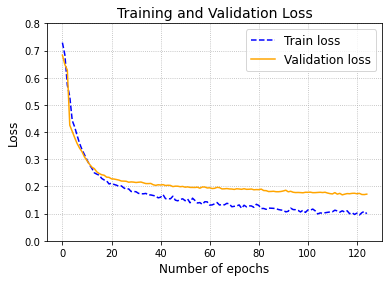

In [27]:

# Get the training history from the best estimator
history = gridsearch_lr.best_estimator_.history

# Extract the training and validation loss values
train_loss = history[:, 'train_loss']
valid_loss = history[:, 'valid_loss']

# Plot the training and validation loss against the number of epochs
plt.plot(train_loss, label='Train loss', linestyle='dashed', color='blue')
plt.plot(valid_loss, label='Validation loss', linestyle='solid', color='orange')
plt.xlabel('Number of epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim([0, 0.8])
plt.grid(linestyle='dotted')
plt.show()


As illustrated in the plot, the initial epochs exhibited high validation and training losses. However, following a few epochs, the model began to learn, leading to a considerable reduction in losses. It is noteworthy that the validation losses decreased in parallel with the training losses, indicating that the model learned effectively without overfitting. To avoid overfitting the training process terminated at 120 epochs using the early stopping callback.

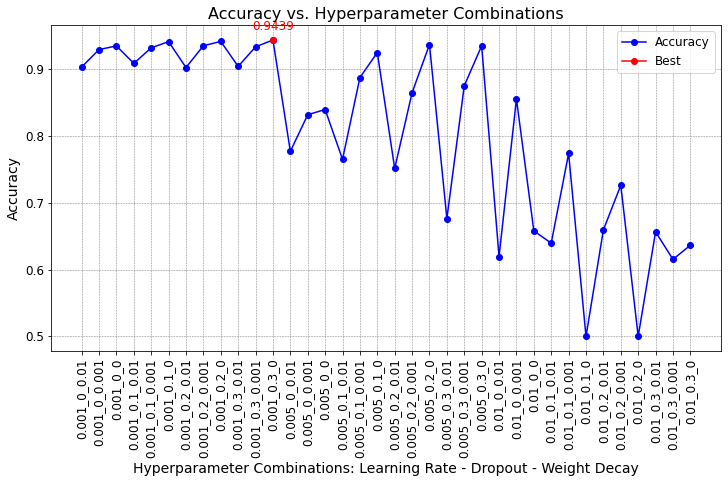

In [23]:
# Get the grid search results
results = gridsearch_lr.cv_results_

# Extract the parameter combinations and the corresponding accuracy scores
params = results['params']
mean_scores = results['mean_test_score']

# Create a list of labels for the x-axis based on the parameter combinations
labels = [str(p) for p in params]
labels = [f"{p['lr']}_{p['module__dropout']}_{p['optimizer__weight_decay']}" for p in params]

# Determine the hyperparameter combination with the highest accuracy
best_index = mean_scores.argmax()
best_label = labels[best_index]
best_score = mean_scores[best_index]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the mean test scores
ax.plot(labels, mean_scores, color='blue', marker='o')

# Plot the point with the highest accuracy
ax.plot(best_label, best_score, color='red', marker='o')

# Set the title and axis labels
ax.set_title('Accuracy vs. Hyperparameter Combinations', fontsize=16)
ax.set_xlabel('Hyperparameter Combinations: Learning Rate - Dropout - Weight Decay', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Set the axis tick label font size
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add gridlines
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Add a text to indicate the point with the highest accuracy
ax.text(best_label, best_score+0.01, f"{best_score:.4f}", color='red', fontsize=12, ha='center', va='bottom')

# Add a legend
ax.legend(['Accuracy', 'Best'], fontsize=12)

# Show the plot
plt.show()


# Appendix

In [41]:

import pickle

# # Save the gs instance to a file
# with open('gridsearch_lr.pickle', 'wb') as f:
#     pickle.dump(gs_lr, f)

# Load the gs instance from the file
with open('gridsearch_lr_appendix.pickle', 'rb') as f:
    gridsearch_lr_appendix = pickle.load(f)

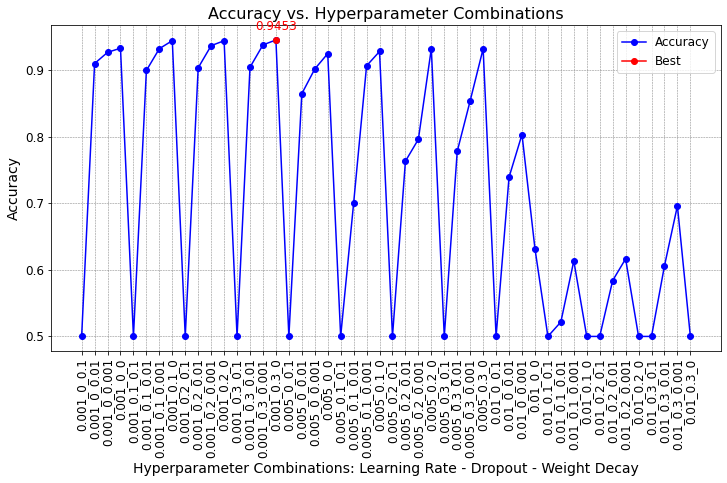

In [42]:
import matplotlib.pyplot as plt

# Get the grid search results
results = gridsearch_lr_appendix.cv_results_

# Extract the parameter combinations and the corresponding accuracy scores
params = results['params']
mean_scores = results['mean_test_score']

# Create a list of labels for the x-axis based on the parameter combinations
labels = [str(p) for p in params]
labels = [f"{p['lr']}_{p['module__dropout']}_{p['optimizer__weight_decay']}" for p in params]

# Determine the hyperparameter combination with the highest accuracy
best_index = mean_scores.argmax()
best_label = labels[best_index]
best_score = mean_scores[best_index]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the mean test scores
ax.plot(labels, mean_scores, color='blue', marker='o')

# Plot the point with the highest accuracy
ax.plot(best_label, best_score, color='red', marker='o')

# Set the title and axis labels
ax.set_title('Accuracy vs. Hyperparameter Combinations', fontsize=16)
ax.set_xlabel('Hyperparameter Combinations: Learning Rate - Dropout - Weight Decay', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Set the axis tick label font size
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add gridlines
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Add a text to indicate the point with the highest accuracy
ax.text(best_label, best_score+0.01, f"{best_score:.4f}", color='red', fontsize=12, ha='center', va='bottom')

# Add a legend
ax.legend(['Accuracy', 'Best'], fontsize=12)

# Show the plot
plt.show()


weight 0.1 is two big so we will delet it from grid search 

Average training time for all models: 130.40 seconds
Average training time for all models: 19.72 seconds


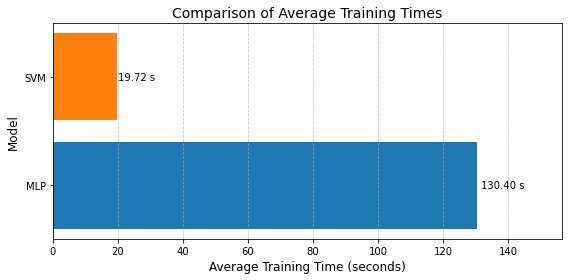

In [34]:
import numpy as np

# Extract the mean fit time for each fold of the cross-validation
cv_times = gridsearch_lr.cv_results_['mean_fit_time']

# Calculate the average training time across all folds
avg_train_time_MLP= np.mean(cv_times)

print("Average training time for all models: {:.2f} seconds".format(avg_train_time_MLP))

cv_times = gridsearch_svm.cv_results_['mean_fit_time']

avg_train_time_svm= np.mean(cv_times)
print("Average training time for all models: {:.2f} seconds".format(avg_train_time_svm))
#########################################################
# Define the data
models = ['MLP', 'SVM']
avg_train_times = [avg_train_time_MLP, avg_train_time_svm]

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(models, avg_train_times, color=['#1f77b4', '#ff7f0e'])

# Add labels and title
ax.set_xlabel('Average Training Time (seconds)', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.set_title('Comparison of Average Training Times', fontsize=14)

# Add gridlines and adjust axis limits
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.set_xlim([0, max(avg_train_times) * 1.2])

# Add data labels
for i, v in enumerate(avg_train_times):
    ax.text(v * 1.01, i, "{:.2f} s".format(v), color='black', fontsize=10, va='center')

# Adjust spacing and display plot
fig.tight_layout()
plt.show()


Upon examining the plot, it is evident that the average time taken to fit each SVM model across five folds during the grid search model is approximately 20 seconds, while training MLP models across five folds of validation data requires over 130 seconds on average. This disparity in computation times highlights the fact that training MLP models can be significantly more computationally expensive compared to SVM models.

